# Patryk Barkowski - projekt
---
### Analiza Danych Elektrofizjologicznych 2017
---
Witam w moim królestwie.<br>Postaram się możliwie uprzyjemnić podróż przez niniejszą pracę - będzie ładnie, wizualnie i - **mam nadzieję!** - przejrzyście. Ponizej spis treści, gdybyśmy się mieli pogubić:
0. przygotowanie do pracy
1. asd
2. awq
3. wrg

ZROBIĆ<br>
Tak jak omawialiśmy na zajęciach - projekt to notebook, w którym przygotowujecie plik do analizy, tzn: POPRAWIC NA 1 OSOBĘ!

* wczytajecie, dodajecie pozycję kanałów, filtrujecie
* epokujecie względem interesujących wydarzeń
* dopasowujecie ICA i oznaczacie komponenty wyjaśniające artefakty w sygnale, czyścicie z nich sygnał
* przeprowadzanie proste porównanie dwóch warunków pod kątem ERP
* przeprowadzacie proste porównanie dwóch warunków pod kątem widma

## 0. przygotowanie do pracy

Na dzień dobry klasyczne i zawsze oczekiwane - powitajmy **os** oraz **mne**!

In [1]:
import os
import mne

Upewaniam się czy plik (wybrałem **CAT110 20131108 2040002.raw**) jest obecny w folderze:

In [2]:
ls

 Volume in drive C has no label.
 Volume Serial Number is 045A-06F7

 Directory of C:\Users\Machina\Desktop\analizadanycheeg\projekt

03.07.2017  17:35    <DIR>          .
03.07.2017  17:35    <DIR>          ..
03.07.2017  17:27    <DIR>          .ipynb_checkpoints
01.07.2017  19:11         1˙125˙157 12.ipynb
23.05.2017  21:53        51˙829˙776 CAT110 20131108 2040002.raw
03.07.2017  08:28                45 proj
03.07.2017  17:35         4˙513˙710 proj2017patrykbarkowski.ipynb
03.07.2017  08:27                17 README.md
               5 File(s)     57˙468˙705 bytes
               3 Dir(s)   9˙887˙358˙976 bytes free


Na koniec żeby nie męczyć się za mocno z kopiowaniem nazwy, zrobię zmienną z nazwą pliku:

In [3]:
plik = "CAT110 20131108 2040002.raw"

## 1. wczytywanie pliku


Klasyczna komenta dla wczytaniu pliku z rozszerzeniem .raw:

In [4]:
dane = mne.io.read_raw_egi(plik, preload=True)

Reading EGI header from CAT110 20131108 2040002.raw...
    Reading events ...
    Assembling measurement info ...
    Synthesizing trigger channel "STI 014" ...
    Excluding events {} ...
    Found multiple events at the same time sample. Cannot create trigger channel.
Reading 0 ... 177498  =      0.000 ...   709.992 secs...


Sprawdzmy szybko ile kanałów ma nasz sygnał:

In [5]:
dane

<RawEGI  |  CAT110 20131108 2040002.raw, n_channels x n_times : 73 x 177499 (710.0 sec), ~99.0 MB, data loaded>

73 kanały, nieźle!

In [6]:
%matplotlib inline

In [13]:
%matplotlib


Using matplotlib backend: Qt5Agg


## 2. filtrowanie


Zastosuję następujące filtry: górno-przepustowy 1Hz oraz low transition bandwith 0,25Hz.

Dodatkowo, zgodnie z wskazówkami z zajęć, kopiuję dane tak, aby nie ingerować w oryginalny surowy sygnał.

In [7]:
dane2 = dane.copy()
dane2.filter(1, None, l_trans_bandwidth=0.25)

Setting up high-pass filter at 1 Hz
Filter length of 6600 samples (26.400 sec) selected


<RawEGI  |  CAT110 20131108 2040002.raw, n_channels x n_times : 73 x 177499 (710.0 sec), ~99.0 MB, data loaded>

Porównam sobie sygnał sprzed filtrowania...

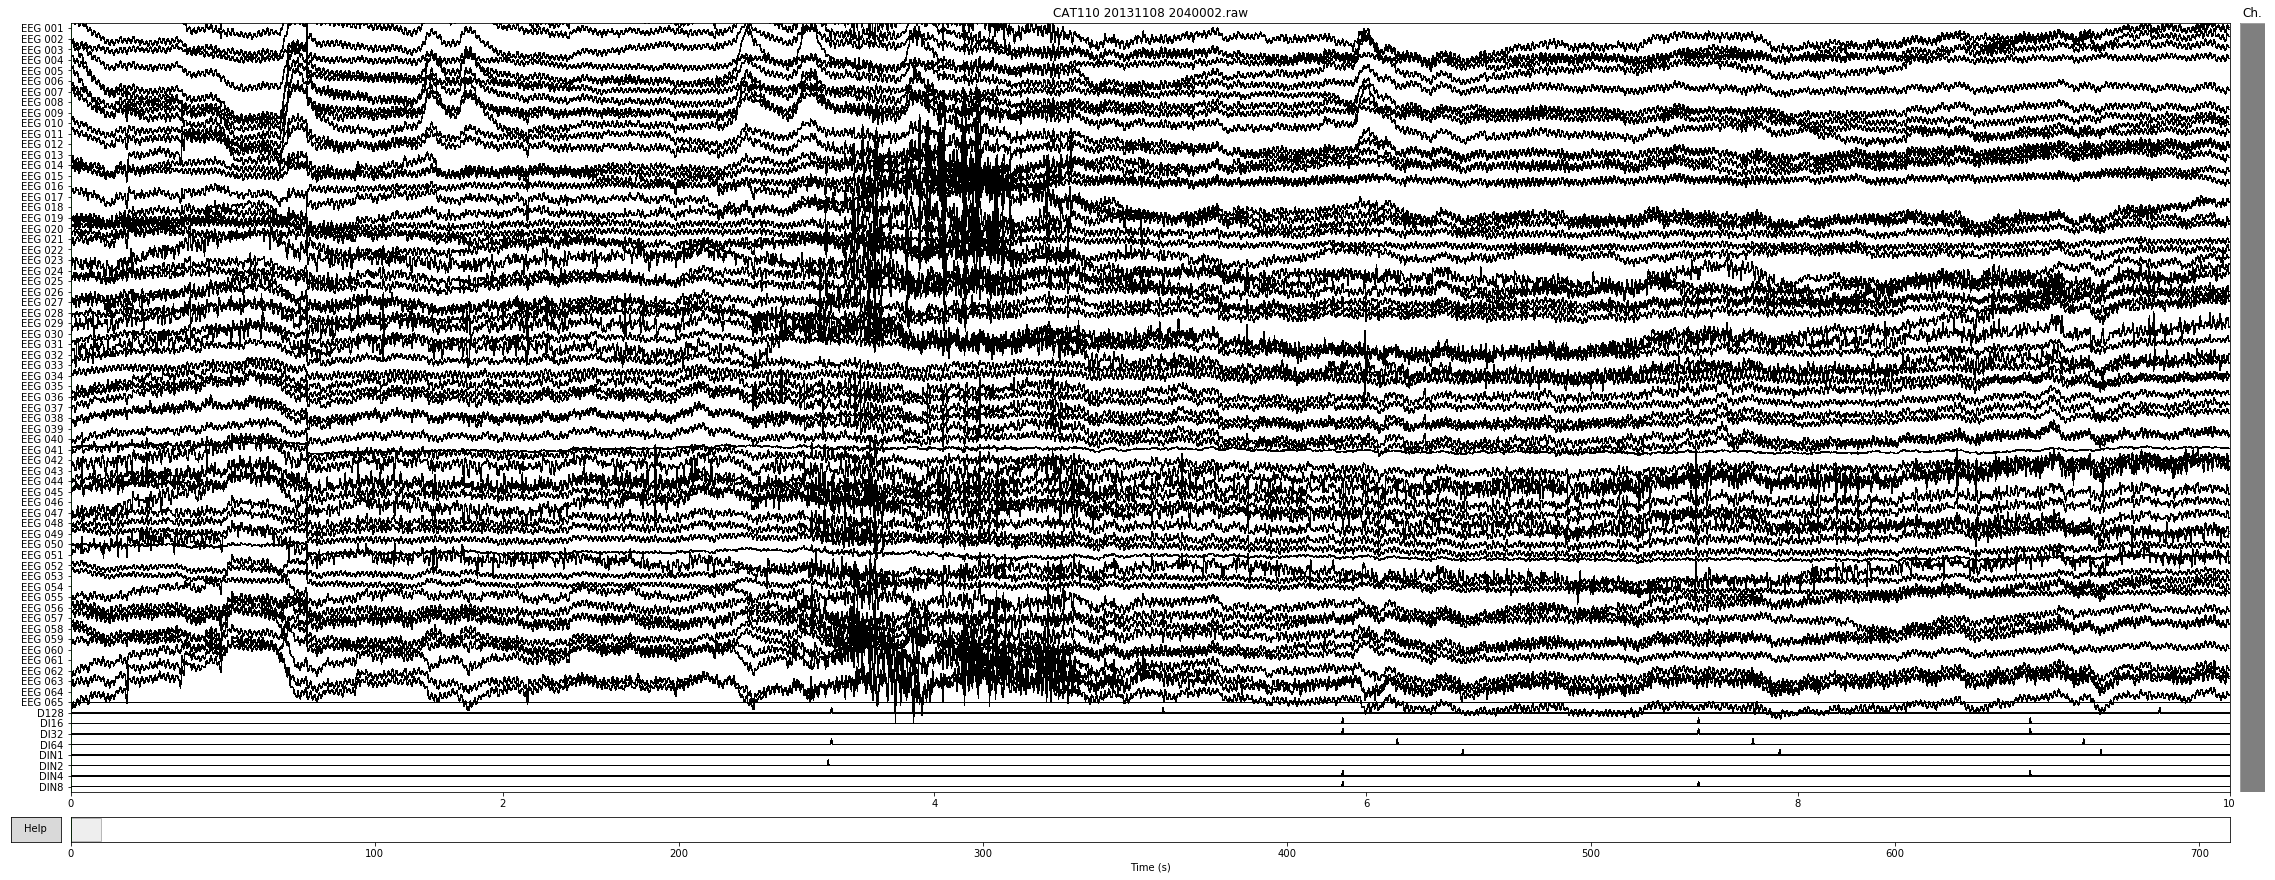

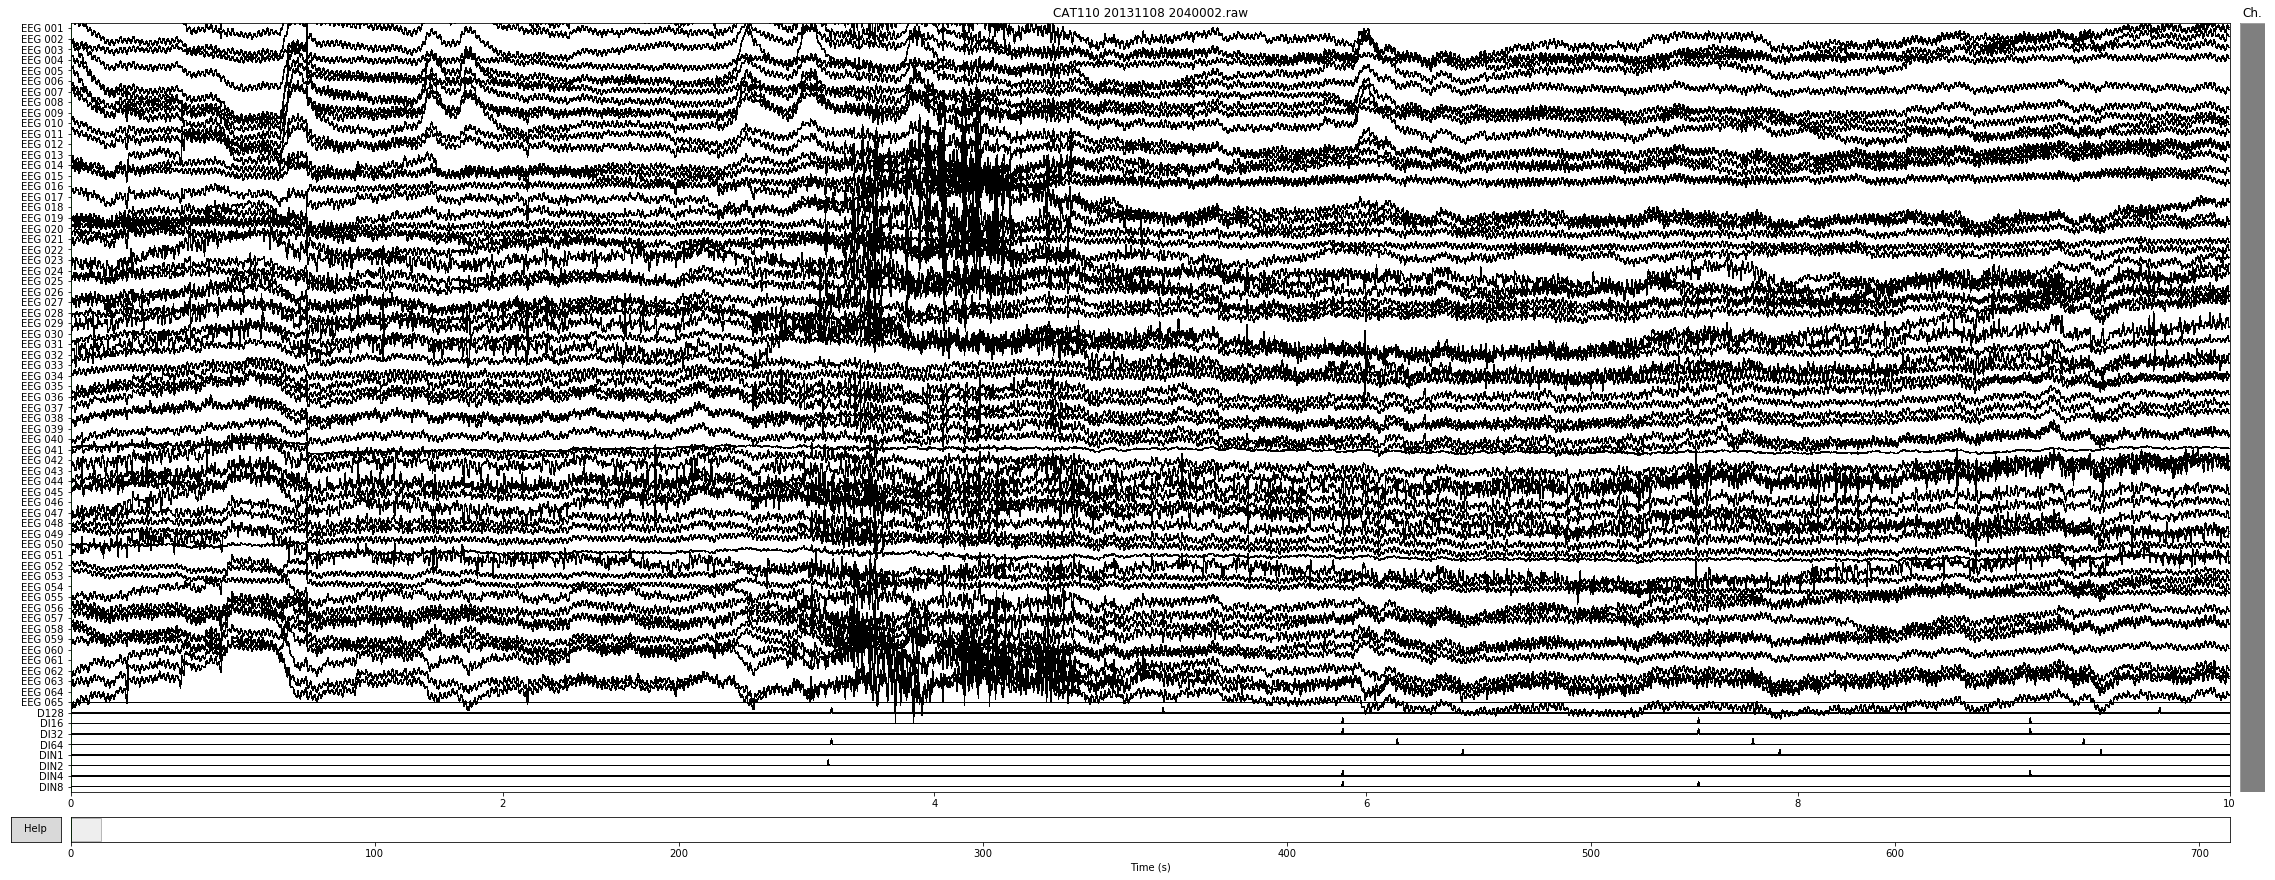

In [8]:
dane.plot(start=0, n_channels=73)

... oraz efekt po filtowaniu, upewniam się, że sygnał zauważanie mniej "pływa":

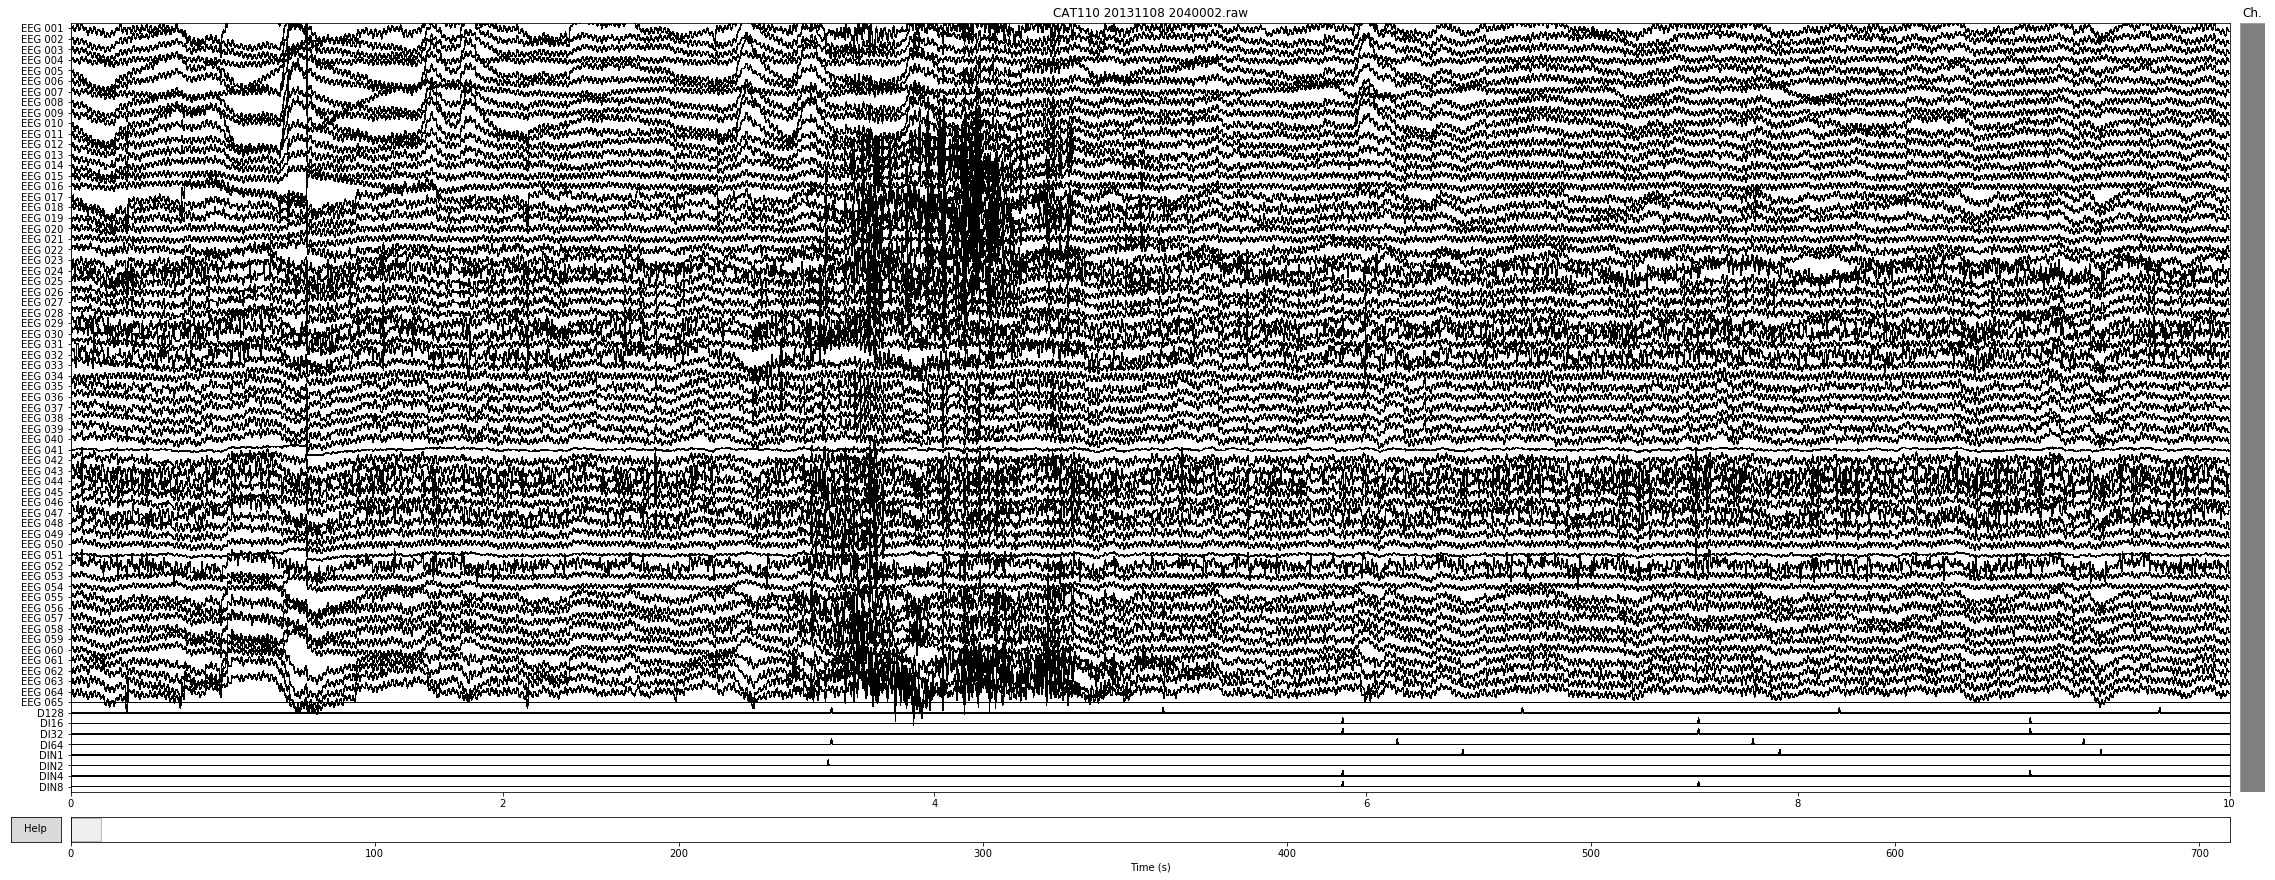

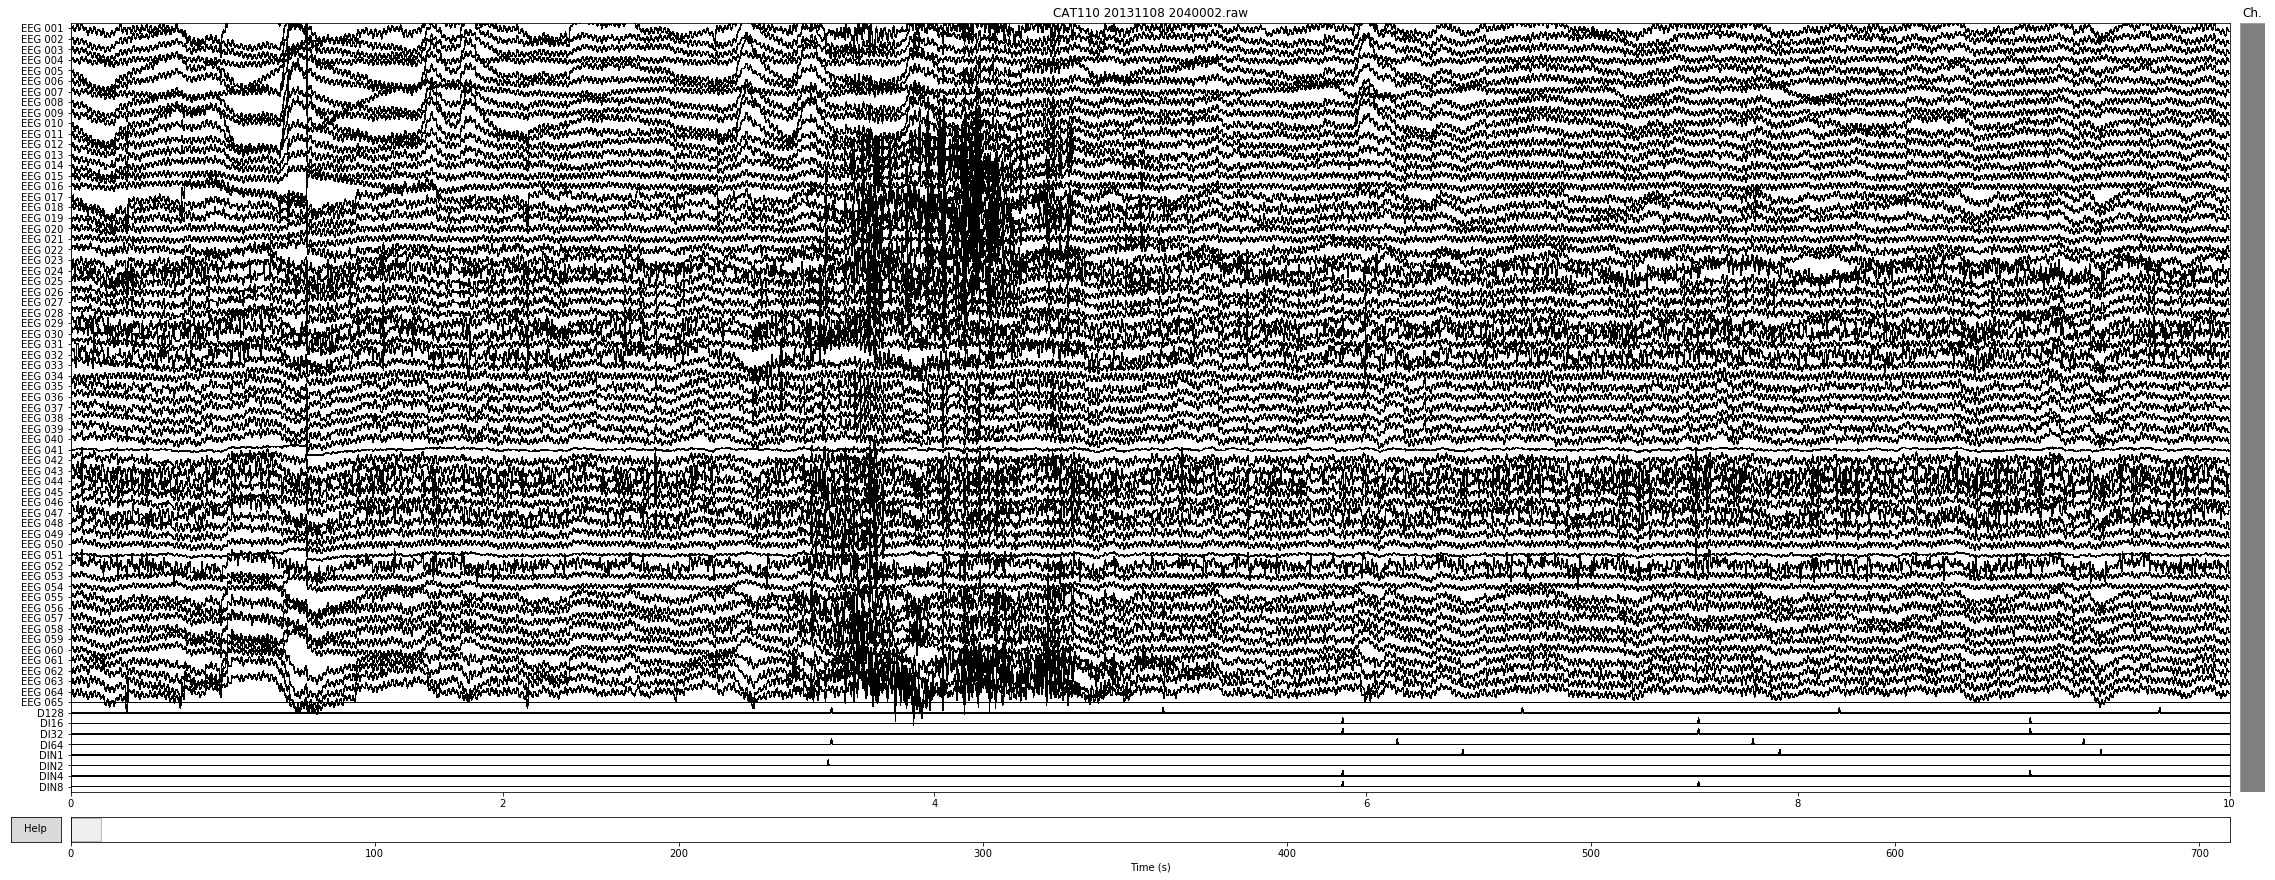

In [9]:
dane2.plot(start=0, n_channels=73)

## 3. pozycje elektrod


Ponieważ kanały nazywające się np. EEG033 nie dają nam jakiejkolwiek informacji, muszę wczytać odpowiedni montaż. Zgodnie z instrukcją, będzie to **GSN-HydroCel-65_1.0**. Nie będę tworzył zmiennych jak na zajęciach, ponieważ później nie przydadzą mi się w projekcie.

In [10]:
mne.channels.read_montage('GSN-HydroCel-65_1.0')

<Montage | GSN-HydroCel-65_1.0 - 68 channels: FidNz, FidT9, FidT10 ...>

Zmieniam nazwy kanałów zgodnie z instrukcją z "bolączek", jednocześniej upewniając się, że zmiana jest zgodna z tym, co chciałem osiągnąć - czyli zmianą z EEG001 na E1, EEG02 na E2 i tak dalej:

In [11]:
from mypy.chans import correct_egi_channel_names

correct_egi_channel_names(dane2)
print(dane2.ch_names[:8])

['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8']


In [12]:
dane2.set_montage(mne.channels.read_montage('GSN-HydroCel-65_1.0'))

Szybko upewnię się, że mam nowe nazwy:

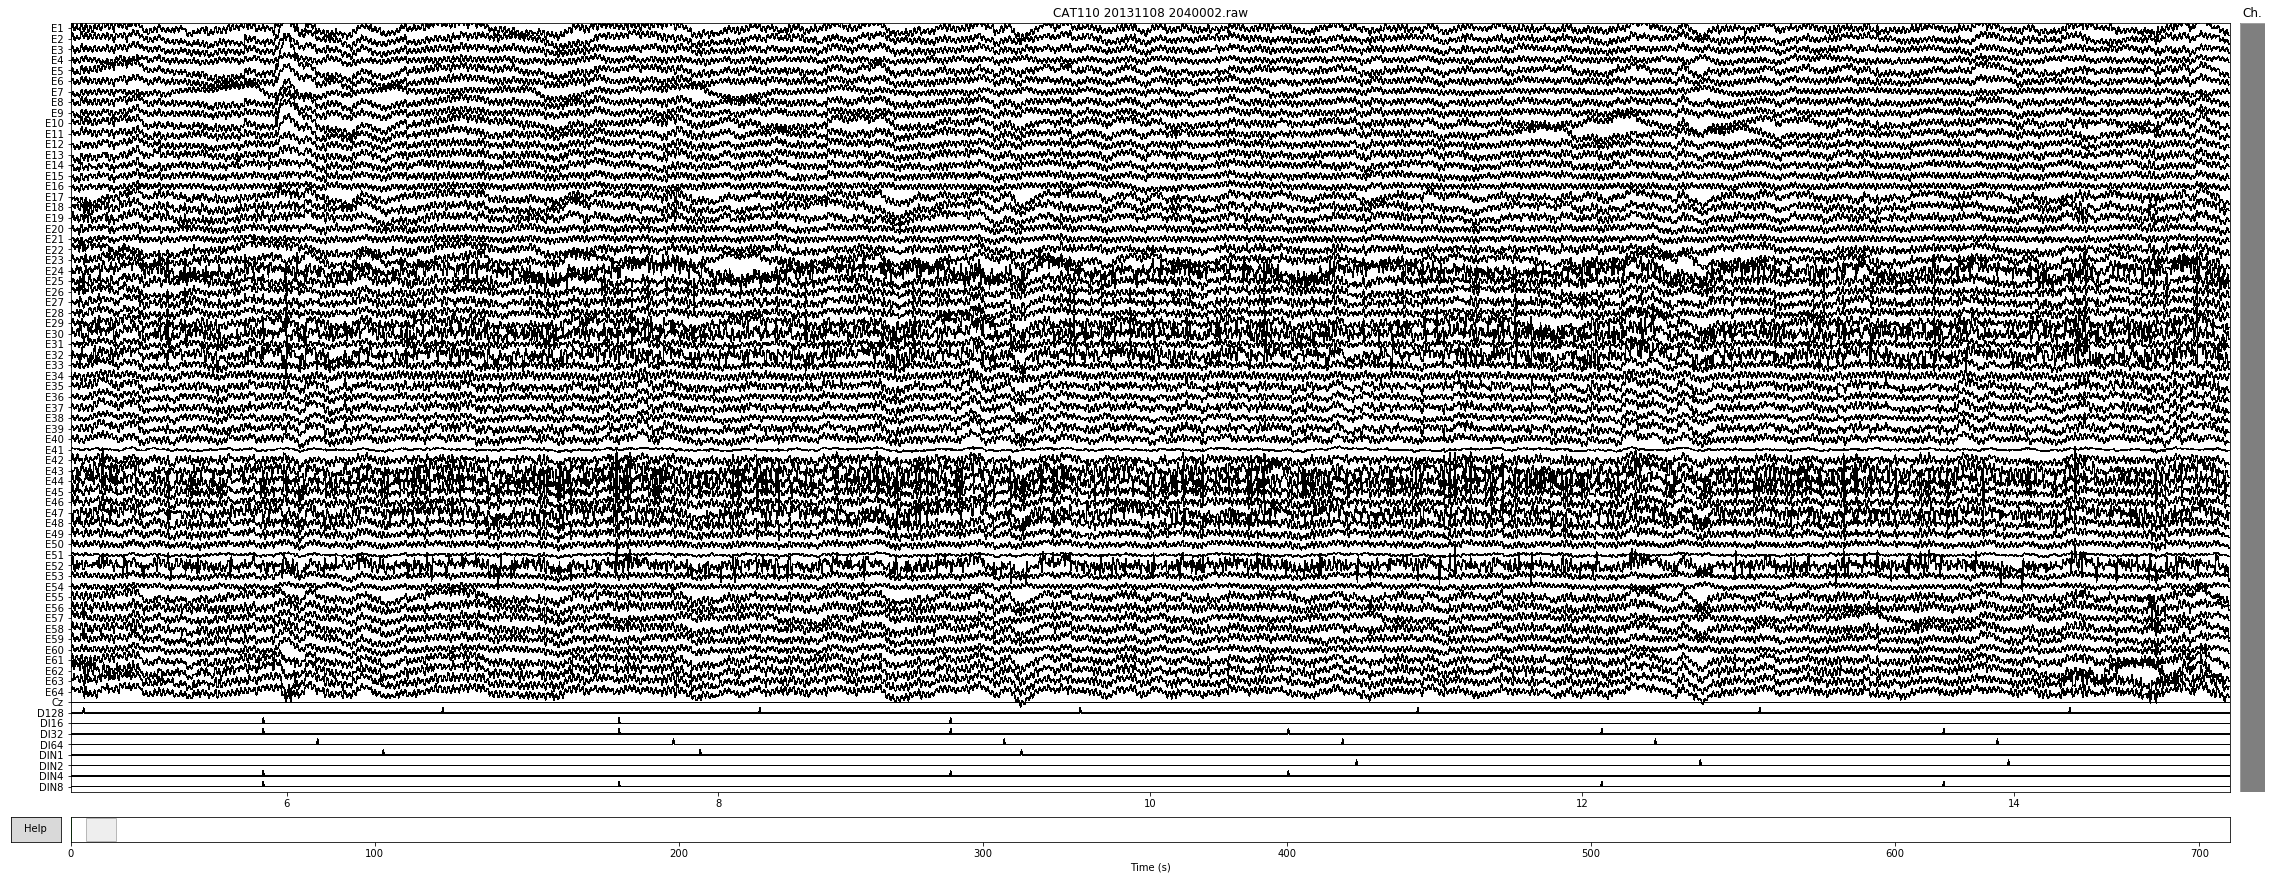

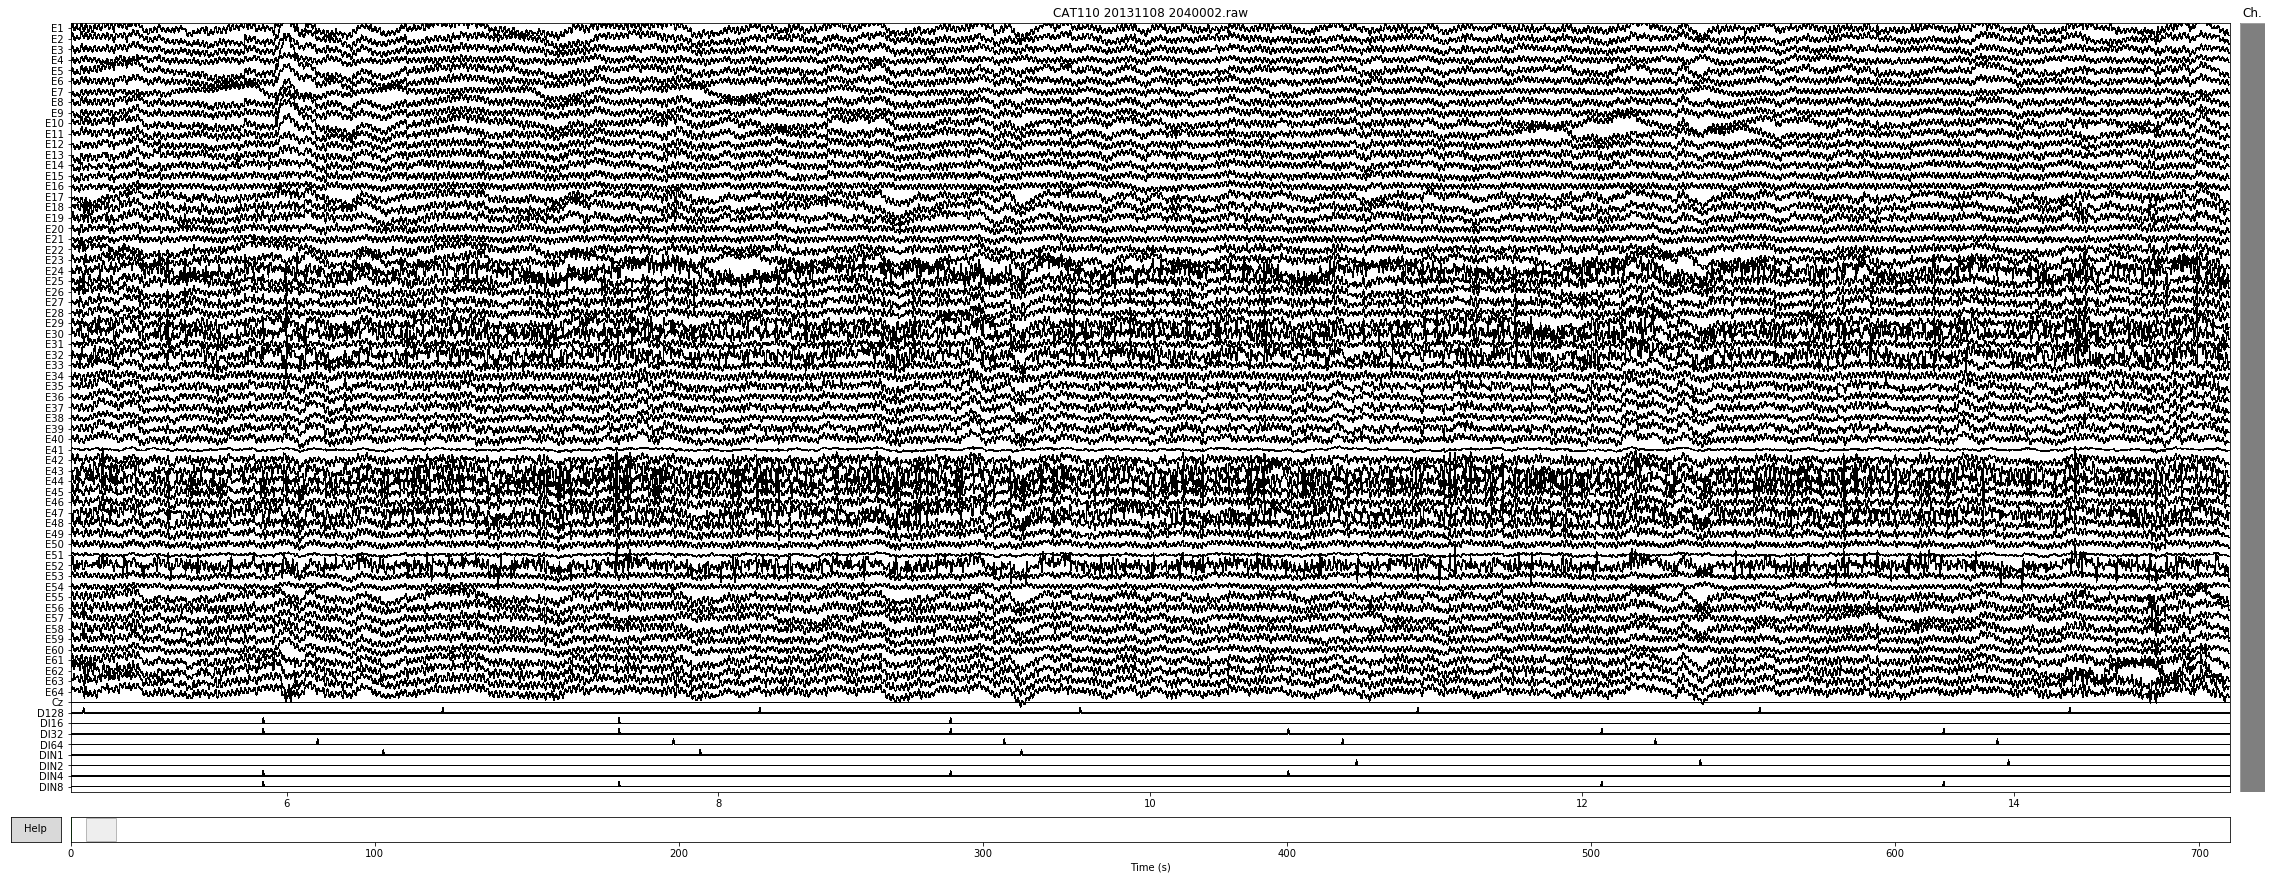

In [13]:
dane2.plot(start=5, n_channels=73)

Sukces! Czas na..

## 4. epokowanie
### 4.1 tworzenie wydarzeń

Dla przypomnienia oraz ułatwienia kolejnych etapów pracy, szybka przypominajka wartości wydarzeń w procedurze "twarze i samochody":
* 1 - osoba badana wciska strzałkę w lewo
* 2 - osoba badana wciska strzałkę w prawo
* 3 - osoba badana wciska spację
* 36 - na ekranie prezentowany jest samochód pod kątem 0 stopni
* 40 - na ekranie prezentowany jest samochód pod kątem 90 stopni
* 44 - na ekranie prezentowany jest samochód pod kątem 180 stopni (do góry "nogami")
* 52 - na ekranie prezentowana jest twarz pod kątem 0 stopni
* 56 - na ekranie prezentowana jest twarz pod kątem 90 stopni
* 60 - na ekranie prezentowana jest twarz pod kątem 180 stopni (do góry nogami)
* 128 - na erkanie pojawia się krzyżyk fiksacji I jeszcze kilka innych wydarzń, które nie są tak ważne.

Najpierw wyciagnę informację z kanałów DIN ze zmianą na konkretne, wyżej opisane wydarzenia:

In [14]:
import mypy
wydarzenia = mypy.events.get_events_from_din(dane2)

A następnie usuwam niepotrzebne już kanały DIN:

In [15]:
dane2.drop_channels(['DIN1', 'DIN2', 'DIN4', 'DIN8', 'DI16', 'DI32', 'DI64', 'D128'])

<RawEGI  |  CAT110 20131108 2040002.raw, n_channels x n_times : 65 x 177499 (710.0 sec), ~88.1 MB, data loaded>

Obecna wartość w n_channels=65, czyli z pierwotnych 73 wypadło 8 (tyle ile wyżej zdefiniowanych). So far so good!

### 4.2 tworzenie epok w oparciu o wydarzenia

Ważny moment: wybieram, które wydarzenia są dla mnie ważne. Dalej opiszę dlaczego wybrałem te konkretne, co będę ze sobą porównywał i tym podobne. Póki co poepokuję... wszystko związane z twarzami i samochodami. Będzie trochę pracy przy zaznaczniu złych epok, ale czego nie robi się w imię nauki? Epokuję po 0,5 sekundy przed i po bodźcu.

In [16]:
doepokowania = [36, 40, 44, 52, 56, 60, 128]

In [37]:
epoki = mne.Epochs(dane2, events=wydarzenia, event_id=doepokowania,
                   tmin=-0.5, tmax=0.5, preload=True)

825 matching events found
0 projection items activated
Loading data for 825 events and 251 original time points ...
0 bad epochs dropped


Super! 825! Epok! Do! Przeglądania!

### 4.3 przeglądanie złych epok i ich usuwanie

In [18]:
%matplotlib inline

In [38]:
%matplotlib

Using matplotlib backend: Qt5Agg


In [39]:
epoki.plot(n_channels=64, n_epochs=6);

Dropped 43 epochs
Channels marked as bad: []


Przykład wyrzuconych epok:

Niestety, wrzucam zrzuty ekranu, ponieważ próba pokazania tych epok w kodzie była bardzo "niewyraźna".

Pliki o nazwach *epoka_miesnie_1, epoka_miesnie_2, epoka_miesnie_3* zawierają przykłądowe artefakty mieśniowe, jakie zaznaczałem do wyrzucenia.

Pliki o nazwach *epoka_mruganie_1, epoka_mruganie_2, epoka_mruganie_3* - zawierają przykłady artefaktów związanych z mruganiem, któ zdecydowałem się zostawić w sygnale, aby później usunąć je przy pomocy ICA.

Pliki o nazwach *epoka_inne_1, epoka_inne_2, epoka_inne_3* - zawierają przykłady "dziwnych" odchyleń od sygnału, które zdecydowałem się odrzucić.

# **WYCZYSCICCCCCCCCC!!!!!!!!!!!!**

## 5. ICA
Jakby powiedział Mikołaj na zajęciach: "czas zająć się ICA i wyczyścić dobrze te dane."
### 5.1 dopasowanie ICA

Najpierw referencja do średniej:

In [41]:
epoki.set_eeg_reference()
epoki.apply_proj()

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but hasn't been applied yet. Use the .apply_proj() method function to apply projections.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


<Epochs  |  n_events : 782 (all good), tmin : -0.5 (s), tmax : 0.5 (s), baseline : (None, 0), ~97.5 MB, data loaded,
 '128': 378, '36': 68, '40': 67, '44': 65, '52': 67, '56': 69, '60': 68>

In [42]:
from mne.preprocessing import ICA
ica = ICA(method='extended-infomax', n_components=0.99)
print(ica)

<ICA  |  no decomposition, fit (extended-infomax):  samples, no dimension reduction>


In [43]:
ica.fit(epoki)

Fitting ICA to data using 65 channels. 
Please be patient, this may take some time
Inferring max_pca_components from picks.
Selection by explained variance: 46 components
computing Extended Infomax ICA


<ICA  |  epochs decomposition, fit (extended-infomax): 196282 samples, 46 components, channels used: "eeg">

In [48]:
%matplotlib inline

In [45]:
%matplotlib

Using matplotlib backend: Qt5Agg


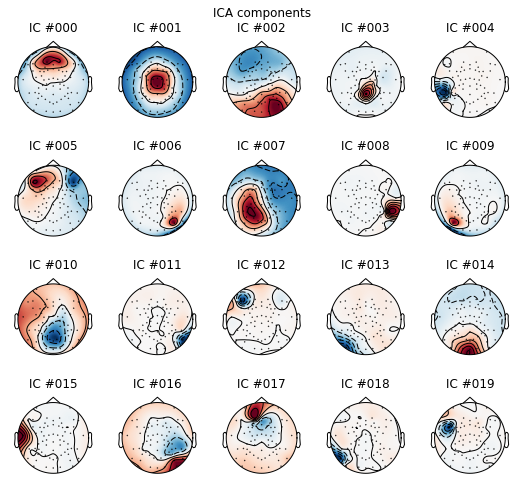

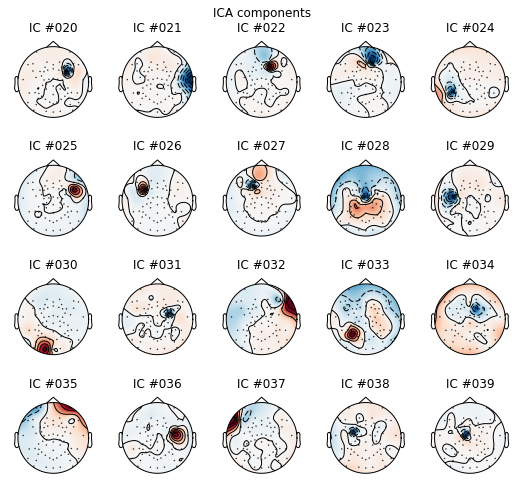

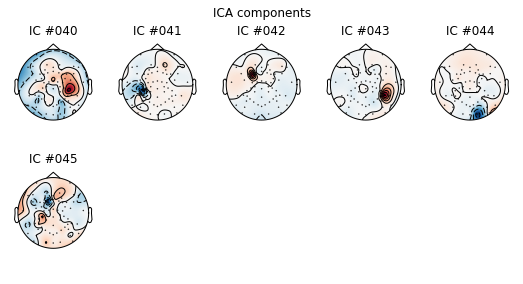

In [53]:
ica.plot_components(inst=epoki)

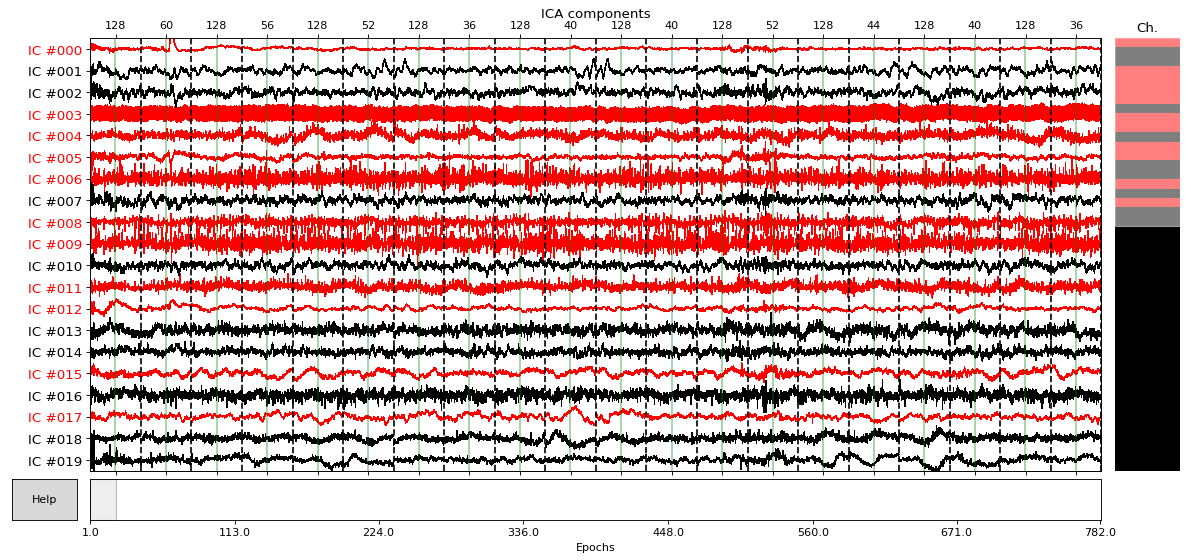

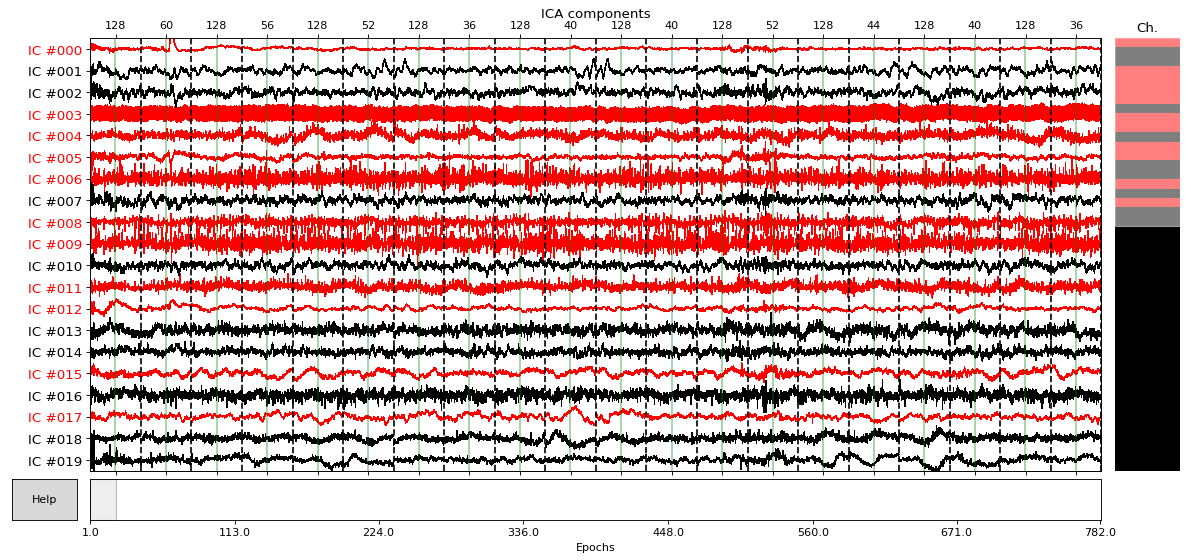

In [51]:
ica.plot_sources(epoki)

Na podstawie map cieplnych oraz plotu komponentów, decyduję się odrzucić powyższe, wskazane na czerwono.
Poniżej powody, dla których decydowałem się odrzucać dany komponent:

**Artefakt związany z oczyma - mruganie?**

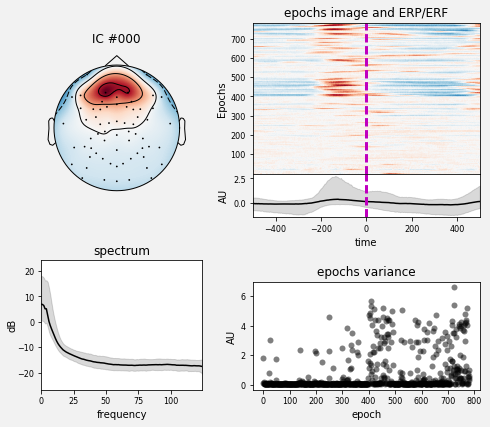

In [50]:
ica.plot_properties(picks=0, inst=epoki, image_args=dict(sigma=2.5))

**Artefakt związany z siecią:**

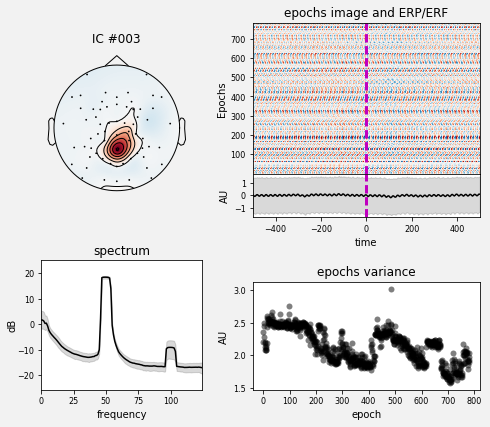

In [52]:
ica.plot_properties(picks=3, inst=epoki, image_args=dict(sigma=2.5))

**Ruchy horyzontalne oczu:**

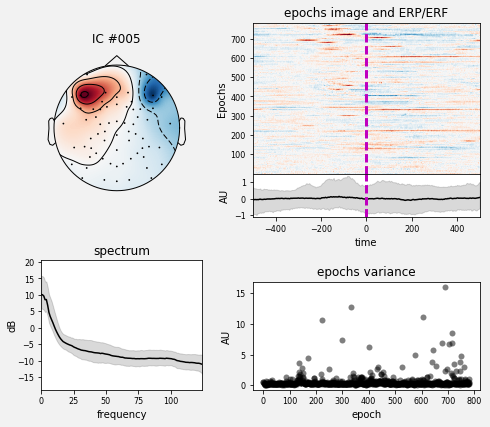

In [54]:
ica.plot_properties(picks=5, inst=epoki, image_args=dict(sigma=2.5))

**Artefakty mięśniowe i/lub zwiazane z jedną elektrodą:**

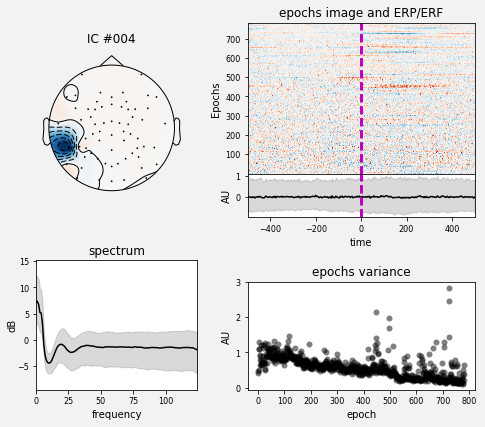

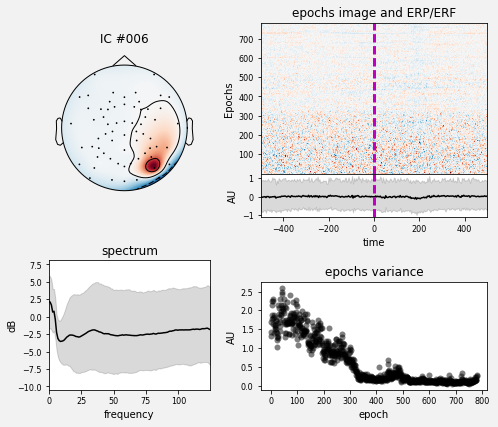

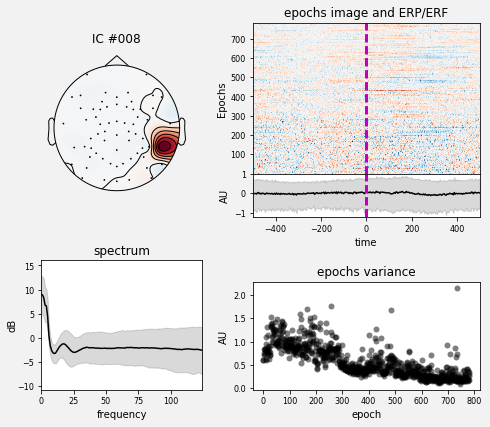

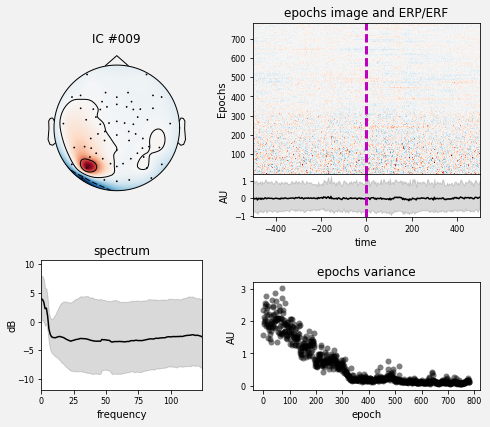

In [55]:
ica.plot_properties(picks=[4, 6, 8, 9], inst=epoki, image_args=dict(sigma=2.5))

**Artefakty mięśniowe:**

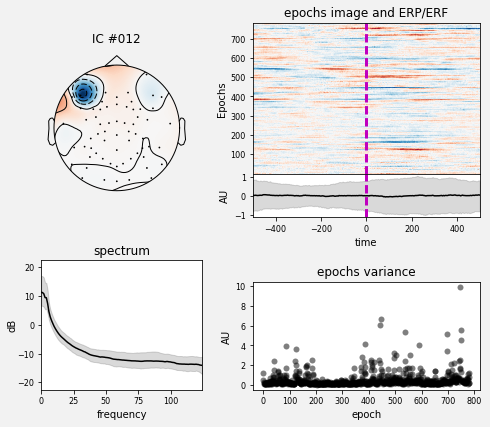

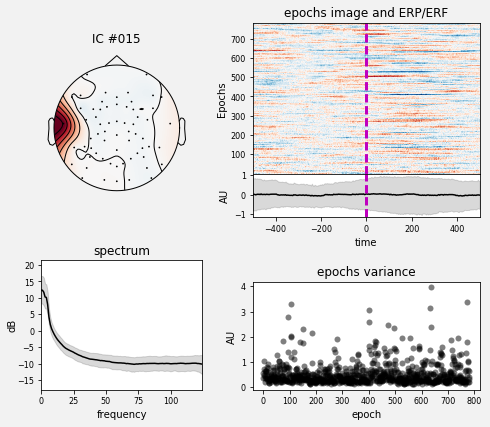

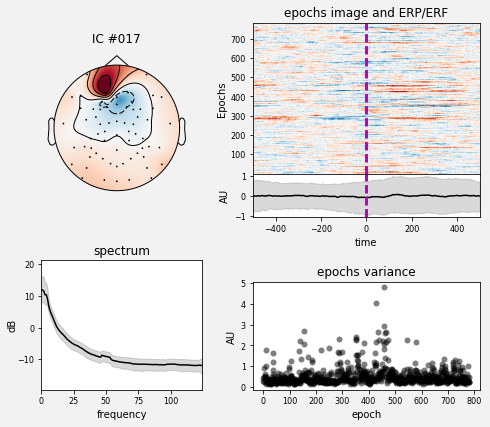

In [56]:
ica.plot_properties(picks=[12, 15, 17], inst=epoki, image_args=dict(sigma=2.5))

Sprawdzam zaznaczone komponenty:

In [57]:
ica.exclude

[0, 3, 4, 5, 6, 8, 9, 11, 12, 15, 17]

I klasyczną wskazówką - pracując na kopii - usuwam komponenty:

In [58]:
epoki_czyste = ica.apply(epoki.copy())

Transforming to ICA space (46 components)
Zeroing out 11 ICA components


## 7. porównania w domenie czase - ERPy

Przypominajka - poepokowałem sobie sygnał według następujących wydarzeń:
* 36 - na ekranie prezentowany jest samochód pod kątem 0 stopni
* 40 - na ekranie prezentowany jest samochód pod kątem 90 stopni
* 44 - na ekranie prezentowany jest samochód pod kątem 180 stopni (do góry "nogami")
* 52 - na ekranie prezentowana jest twarz pod kątem 0 stopni
* 56 - na ekranie prezentowana jest twarz pod kątem 90 stopni
* 60 - na ekranie prezentowana jest twarz pod kątem 180 stopni (do góry nogami)

Najpierw przycinamy epoki na 0,2s przed bodźcem (po bodźcu bez zmian, tj. 0,5s)

In [92]:
epoki_erp = epoki_czyste.copy().crop(tmin=-0.2)

I "wybieram" Peakchu, któy pomoże mi znaleźć najlepsze dla porównań elektrody:

In [93]:
from mypy.chans import Peakachu

No i będę porównywał wiecej niż 2 warunki, mam nadzieję, żę się nie obrazisz :)

### 7.1 porównanie ERP dla samochodów widocznych pod różnymi kątami:

Najpierw uśredniam epoki wybranych wydarzeń w ERPy, jednocześnie zapisując je w zmiennych:

In [94]:
erp_auto_0 = epoki_erp['36'].average()
erp_auto_90 = epoki_erp['40'].average()
erp_auto_180 = epoki_erp['44'].average()

Następnie wyszukuję :najciekawsze załamki:

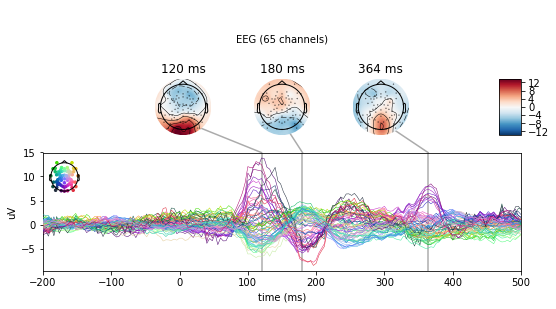

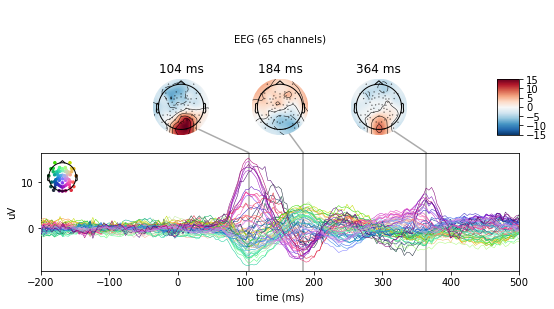

In [95]:
erp_auto_0.plot_joint();
erp_auto_90.plot_joint();
erp_auto_180.plot_joint();

Podoba mi się ten załamek około P100, szukam najlepszych elektrod dla wszystkich warunków. Poszukam 2 najlepsze elektrody, tak aby znaleźć jakiekolwiek wspólne:

In [113]:
pika_auto = Peakachu(mode='P100', n_channels=3)

Auto w normalnej pozycji:

In [114]:
pika_auto.fit(erp_auto_0)
pika_auto.plot_topomap();

Auto odwrócone o 90\*:

In [115]:
pika_auto.fit(erp_auto_90)
pika_auto.plot_topomap();

Auto odwrócone o 180\*:

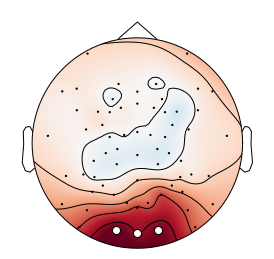

In [116]:
pika_auto.fit(erp_auto_180)
pika_auto.plot_topomap();

Ok, wybiorę 2 elektrody, które składają się na każdy warunek. Wyciągnę z  je z auta odwróconego o 90\*:

In [117]:
print("wybrane kanały to", pika_auto._chan_names)
print("ich indeksy to", pika_auto._chan_ind)

wybrane kanały to ['E37', 'E39', 'E35']
ich indeksy to [36, 38, 34]


In [72]:
%matplotlib inline

In [118]:
auta = {'auto normalnie': erp_auto_0, 'auto odwrócone o 90*': erp_auto_90, 'auto odwrócone o 180*': erp_auto_180}

In [120]:
mne.viz.plot_compare_evokeds(auta, picks=[36, 34, 38]);

Bardzo, moim zdaniem, ciekawy wniosek: przeciętna reakcja na samochód widziany normalnie oraz odwócony o 180\* jest niemal taka sama. Znaczący wzrost w załamku P100 widzimy w przypadku auta odwróconego tylko(?) o 90\*. Później, w okolicach 360ms widzimy większą reakcję na auto odwrócone o 180\*.

### 7.2 porównanie ERP twarzy widocznych pod różnymi kątami:

In [61]:
erp_twarz_0 = epoki_erp['52'].average()
erp_twarz_90 = epoki_erp['56'].average()
erp_twarz_180 = epoki_erp['60'].average()

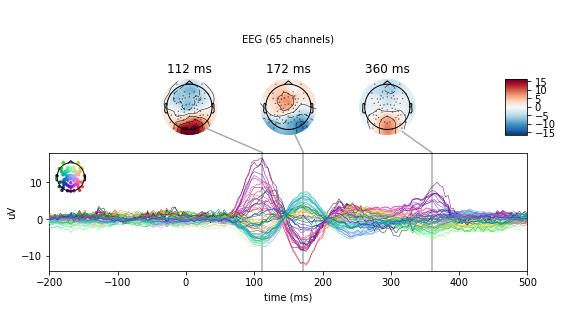

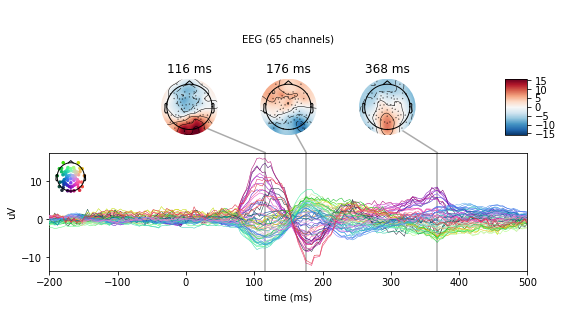

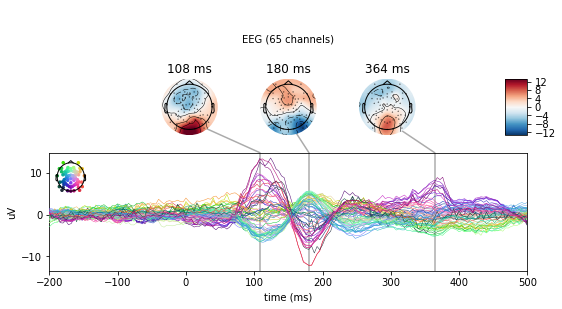

In [62]:
erp_twarz_0.plot_joint();
erp_twarz_90.plot_joint();
erp_twarz_180.plot_joint();

Ponownie wybieram załamek P100, szukam najlepszych elektrod dla wszystkich warunków. Poszukam 3 najlepsze elektrody, tak aby znaleźć jakiekolwiek wspólne:

In [121]:
pika_twarz = Peakachu(mode='P100', n_channels=3)

Twarz w normalnej pozycji:

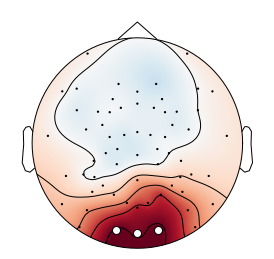

In [122]:
pika_twarz.fit(erp_twarz_0)
pika_twarz.plot_topomap();

Twarz odwrócona o 90\*:

In [123]:
pika_twarz.fit(erp_twarz_90)
pika_twarz.plot_topomap();

Twarz odwrócona o 180\*:

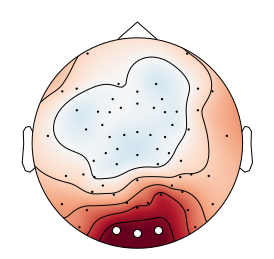

In [124]:
pika_twarz.fit(erp_twarz_180)
pika_twarz.plot_topomap();

Super! We wszystkich trzech warunkach "najmocniejsze" są te same elektrody! Wyciągnę sobie ich kanały i indeksy:

In [125]:
print("wybrane kanały to", pika_twarz._chan_names)
print("ich indeksy to", pika_twarz._chan_ind)

wybrane kanały to ['E39', 'E37', 'E35']
ich indeksy to [38, 36, 34]


Stworzę słownik, przecież obiecałem, że wszystko ma być czytelnie:

In [126]:
twarze = {'twarz normalnie': erp_twarz_0, 'twarz odwrócona o 90*': erp_twarz_90, 'twarz odwrócona o 180*': erp_twarz_180}

In [127]:
mne.viz.plot_compare_evokeds(twarze, picks=[34, 36, 38]);

Małe wnioski: po uśrednionych epokach widzę, że reakcja na twarz widzaną "prosto" była nieco mocniejsza. Potwierdza się również teoria o specyficznym załamku N170, rejestrowanym podczas oglądania twarzy. Tutaj również zaobserwowaliśmy mocniejszą oraz nieznacznie wcześniejszą reakcję.

### 7.2 porównanie ERP twarzy i samochodu widzianego prosto: